In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tvtf
import torchvision.transforms.functional as TF

import time
from tqdm import tqdm
from functools import wraps
import matplotlib.pyplot as plt

from datasets import MNIST_rot
from g_selfatt.utils import num_params
from train_vit import VisionTransformer

/home/wouter/miniconda3/envs/dl2023/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/wouter/miniconda3/envs/dl2023/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/wouter/miniconda3/envs/dl2023/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [64]:
def timeit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Function '{func.__name__}' took {end_time - start_time:.4f} seconds")
        return result
    return wrapper

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformer(embed_dim=64,
                          hidden_dim=512,
                          num_heads=4,
                          num_layers=6,
                          patch_size=4,
                          num_channels=1,
                          num_patches=49,
                          num_classes=10,
                          dropout=0.1).to(device)
model_path = "saved/results/model.pt"
model.load_state_dict(torch.load(model_path, map_location=device), strict=False)

<All keys matched successfully>

In [15]:
model.eval()  # we will not train these parameters again

In [4]:
data_mean = (0.1307,)
data_stddev = (0.3081,)

transform_train = tvtf.Compose([
    tvtf.RandomRotation(degrees=(-180, 180)),  # random rotation
    tvtf.RandomHorizontalFlip(),  # random horizontal flip with a probability of 0.5
    tvtf.RandomVerticalFlip(),
    tvtf.ToTensor(),
    tvtf.Normalize(data_mean, data_stddev)
])
transform_test = tvtf.Compose(
    [
        tvtf.ToTensor(),
        tvtf.Normalize(data_mean, data_stddev),
    ]
)

train_set = MNIST_rot(root="../data", stage="train", download=True, transform=transform_train, data_fraction=1, only_3_and_8=False)
validation_set = MNIST_rot(root="../data", stage="validation", download=True, transform=transform_test, data_fraction=1, only_3_and_8=False)
test_set = MNIST_rot(root="../data", stage="test", download=True, transform=transform_test, data_fraction=1, only_3_and_8=False)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=128,
    shuffle=True,
    num_workers=4,
)
val_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=128,
    shuffle=True,
    num_workers=4,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=128,
    shuffle=False,
    num_workers=4,
)
img_loader = torch.utils.data.DataLoader(  # single element for visualization purposes
    test_set,
    batch_size=1,
    shuffle=False,
    num_workers=4,
)

In [5]:
def evaluate(model):
    model.eval()
    correct = total = 0
    with torch.no_grad():  # disable gradient calculation during inference
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)  # move inputs and labels to device
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100 * correct / total
    return test_acc

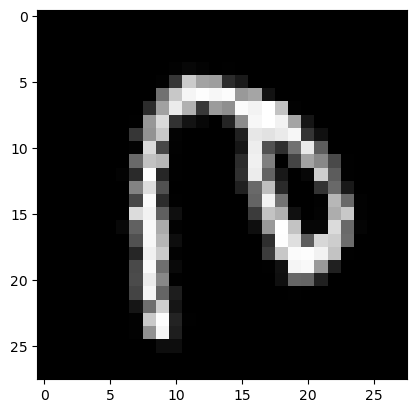

In [7]:
data = iter(img_loader)
image, target = next(data)
plt.imshow(image.squeeze(), cmap="gray")

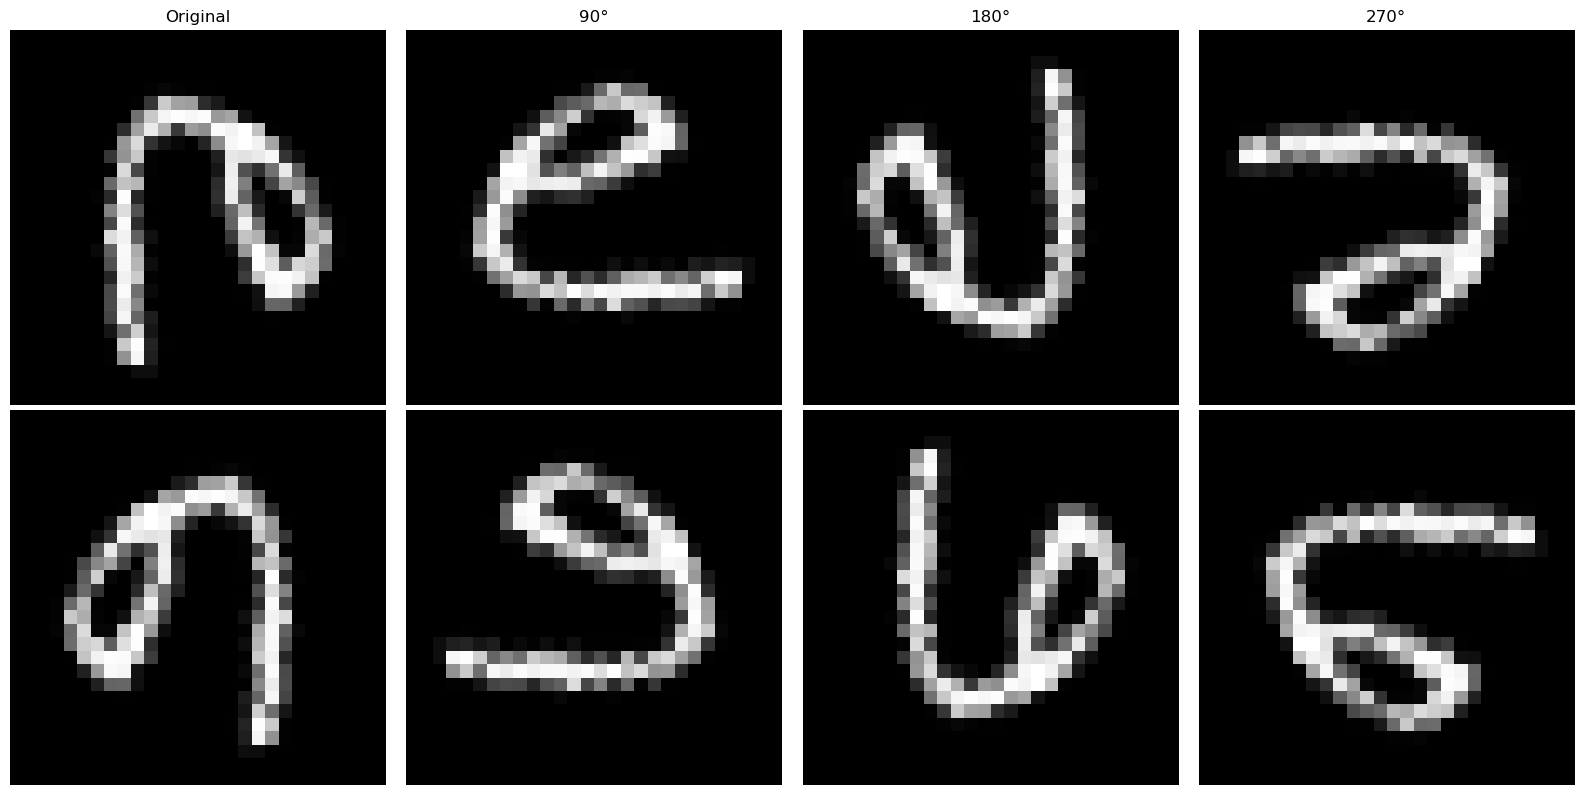

In [8]:
def get_transforms(image, n_rotations=4, flips=True):
    """
    Returns all transformations of a single input image
    """
    transforms = [image]

    # Rotations
    for i in range(1, n_rotations):
        angle = i * (360 / n_rotations)
        rotated_image = TF.rotate(image, angle)
        transforms.append(rotated_image)

    # Flips
    if flips:
        flips = []
        for transform in transforms:
            flipped_image_lr = TF.hflip(transform)
            flips.append(flipped_image_lr)
        # for transform in transforms:
        #     flipped_image_ud = TF.vflip(transform)
        #     flips.append(flipped_image_ud)
        transforms.extend(flips)
        
    res = torch.cat(transforms)
    return res

def visualize_transforms(transformed_images):
    num_images = len(transformed_images)
    num_rows = (num_images - 1) // 4 + 1
    fig, axes = plt.subplots(num_rows, 4, figsize=(16, 4*num_rows))

    for i, img in enumerate(transformed_images):
        row = i // 4
        col = i % 4
        axes[row, col].imshow(img.permute(1, 2, 0), cmap="gray")  # Permute dimensions for visualization
        axes[row, col].axis('off')

    # Hide empty subplots
    for i in range(num_images, num_rows * 4):
        row = i // 4
        col = i % 4
        axes[row, col].axis('off')

    # Labeling axes
    for ax, col in zip(axes[0], ['Original', '90°', '180°', '270°']):
        ax.set_title(col, size="larger")

    plt.tight_layout()
    plt.show()

transformed_images = get_transforms(image)
visualize_transforms(transformed_images)

In [9]:
model.forward(image, output_cls=True).shape, model.forward(get_transforms(image), output_cls=True).shape

(torch.Size([1, 64]), torch.Size([8, 64]))

In [6]:
def get_transforms(images, n_rotations=4, flips=True):
    """ Returns all transformations of the input images """
    
    B, C, H, W = images.shape
    T = 2*n_rotations if flips else n_rotations  # number of transformations

    # initialize empty transforms tensor
    transforms = torch.empty(size=(B, T, C, H, W))
    transforms[:, 0,...] = images
    idx = 1

    # remember all orientations that need to be flipped
    orientations = [images] if flips else []

    # rotations
    for i in range(1, n_rotations):
        angle = i * (360 / n_rotations)
        rotated_images = TF.rotate(images, angle)  # B, C, H, W
        transforms[:, idx,...] = rotated_images
        idx += 1
        
        if flips:
            orientations.append(rotated_images)

    # flips
    for transform in orientations:
        flipped_image = TF.hflip(transform)
        transforms[:, idx, ...] = flipped_image
        idx += 1
        
    return transforms  # B, T, C, H, W

In [10]:
transforms = get_transforms(image)
B, T, C, H, W = transforms.shape
print(transforms.shape)
transforms = transforms.view(B*T, C, H, W)
outputs = model.forward(transforms, output_cls=True)
print(outputs.shape)
outputs = outputs.view(B, T, -1)  # -1 is the dimension of the latent representation
print(outputs.shape)
outputs = outputs.mean(dim=1)  # B, n_dim_repr
print(outputs.shape)
outputs = model.mlp_head(outputs)  # just the pretrained one for now

torch.Size([1, 8, 1, 28, 28])
torch.Size([8, 64])
torch.Size([1, 8, 64])
torch.Size([1, 64])


#### Some possibilities of equivariant combination of the latent representations:
- Mean pooling
- Max pooling
- Sum
- Most probable
- Highest probability among transformations
- Learn weights for weighted average

NOTE: don't forget to freeze earlier layers and to do model.eval() during inference as dropout is used in the model

In [10]:
# TODO come up with fancy names for these variations these suck

class PostHocEquivariant(nn.Module):
    """ Wrapper class for the different types of equivariant models. """

    def __init__(self, model, n_rotations=4, flips=True, finetune=False):
        super().__init__()
        self.model = model
        self.freeze_model_weights(self.model) if finetune else self.unfreeze_model_weights(self.model)
        self.n_rotations = n_rotations
        self.flips = flips
    
    def forward(self, images):
        transforms = get_transforms(images, self.n_rotations, self.flips)
        B, T, C, H, W = transforms.shape
        transforms = transforms.view(B*T, C, H, W)  # process all transformations in one forward pass
        embeddings = self._forward(transforms, B, T)
        logits = self.project_embeddings(embeddings)  # B, num_classes
        return logits
    
    def _forward(self, transforms, B, T):
        embeddings = model.forward(transforms, output_cls=True)  # B*T, n_dim_repr
        embeddings = embeddings.view(B, T, -1)  # B, T, n_dim_repr
        return embeddings

    def project_embeddings(self, embeddings):
        """ 
        The different methods just differently project the latent dimensions. 
        
        Input:
            embeddings - latent dimensions (B, T, n_dim)
                B = number of elements in the batch
                T = number of different transformations of the original input image
                n_dim = the dimension of the latent dimension for a single input
        Output:
            logits (B, n_classes)
        """
        raise NotImplementedError()
    
    def freeze_model_weights(self, model):
        for param in model.parameters():
            param.requires_grad = False
    
    def unfreeze_model_weights(self, model):
        for param in model.parameters():
            param.requires_grad = True

class PostHocEquivariantMean(PostHocEquivariant):
    """ Mean pooling over the different transformations of the image """

    def project_embeddings(self, embeddings):
        combined_embeddings = embeddings.mean(dim=1)  # B, n_dim_repr
        outputs = model.mlp_head(combined_embeddings)  # just the pretrained one for now, works well
        return outputs

class PostHocEquivariantMax(PostHocEquivariant):
    """ Max pooling over the different transformations of the image """

    def project_embeddings(self, embeddings):
        combined_embeddings = embeddings.max(dim=1).values  # B, n_dim_repr
        logits = model.mlp_head(combined_embeddings)  # just the pretrained one for now, surprisingly works
        return logits

class PostHocEquivariantSum(PostHocEquivariant):
    """ Sum over the different transformations of the image """

    def project_embeddings(self, embeddings):
        combined_embeddings = embeddings.sum(dim=1)  # B, n_dim_repr
        logits = model.mlp_head(combined_embeddings)  # just the pretrained one for now
        return logits
    
class PostHocEquivariantMostProbable(PostHocEquivariant):
    """ Predicts the class with the highest class product probability """

    def _forward(self, transforms, B, T):  # overrides parent class method
        logits = model.forward(transforms, output_cls=False)  # B*T, n_classes
        logits = logits.view(B, T, -1)  # B, T, n_classes
        return logits  # here the logits are the embeddings we use

    def project_embeddings(self, embeddings):
        probs = torch.softmax(embeddings, dim=2)  # over the classes
        mle = torch.prod(probs, dim=1)  # over the different transformations 
        mle = mle / mle.sum(dim=1, keepdim=True)  # normalize
        logits = torch.log(mle) - torch.log(1-mle)  # convert to logits
        return logits

class PostHocMostCertain(PostHocEquivariant):
    """ Takes the transformation that assigns highest probability to a class """

    def _forward(self, transforms, B, T):  # overrides parent class method
        logits = model.forward(transforms, output_cls=False)  # B*T, n_classes
        logits = logits.view(B, T, -1)  # B, T, n_classes
        return logits  # here the logits are the embeddings we use

    def project_embeddings(self, embeddings):  # embeddings are logits here
        probs = torch.softmax(embeddings, dim=2)  # over the classes
        idx_highest_probs = torch.argmax(probs, dim=1, keepdim=True)  # among the transformations
        logits = torch.gather(embeddings, 1, idx_highest_probs)  # pluck the ones with the highest prob to some class
        return logits.squeeze(1)

class PostHocLearnedScoreAggregation(PostHocEquivariant):
    """ Given the latent dimension for a transformation, predict an importance weight """

    def __init__(self, model, scoring_model):
        super().__init__(model)
        self.scoring_model = scoring_model
        self.unfreeze_model_weights(self.scoring_model)
    
    def project_embeddings(self, embeddings):
        B, T, n_dim = embeddings.shape
        embeddings = embeddings.view(B*T, n_dim)
        weights = self.scoring_model(embeddings)  # B*T, 1
        weights = weights.view(B, T, 1)
        normalized_weights = weights / weights.sum(dim=1, keepdim=True)  # weighs over orientations sum to one
        embeddings = embeddings.view(B, T, -1)
        weighted_embeddings = embeddings * normalized_weights  # weight all embeddings
        combined_embeddings = weighted_embeddings.sum(dim=1)
        logits = model.mlp_head(combined_embeddings)
        return logits

class PostHocLearnedAggregation(PostHocEquivariant):
    """ Uses a transformer to combine the latent dimensions into a new one """

    def __init__(self, model, aggregation_model):
        super().__init__(model)
        self.aggregation_model = aggregation_model
        self.unfreeze_model_weights(self.aggregation_model)

    def project_embeddings(self, embeddings):
        combined_embeddings = self.aggregation_model(embeddings)
        logits = model.mlp_head(combined_embeddings)
        return logits

In [13]:
# baseline
evaluate(model)

In [15]:
# mean pooling
eq_model_mean = PostHocEquivariantMean(model)
evaluate(eq_model_mean)

In [19]:
# max pooling
eq_model_max = PostHocEquivariantMax(model)
evaluate(eq_model_max)

In [21]:
# summing latent dimensions
eq_model_sum = PostHocEquivariantSum(model)
evaluate(eq_model_sum)

In [26]:
# product of class probabilities
eq_model_most_probable = PostHocEquivariantMostProbable(model)
evaluate(eq_model_most_probable)

In [44]:
# take transformation with highest certainty for class
eq_model_most_certain = PostHocMostCertain(model)
evaluate(eq_model_most_certain)

#### Learn weighs for weighted average

Also here there are a couple of options.
- a) nn takes as input entire latent dimension and outputs scalar representing weight for that dimensions
- b) nn takes as input the i'th entry of each latent dimension, the concatenation is a new latent dimension. Now we have to satisfy equivariance so this order of input should not matter. Use a transformer without PE in this case is a solution.


In [12]:
def train(model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in tqdm(range(5)):
        epoch_losses = []
        for images, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        print(f"Epoch {epoch+1}: loss {sum(epoch_losses)/len(epoch_losses):.4f}")

In [73]:
# a)
class ScoringModel(nn.Module):
    def __init__(self, n_dim=64):
        super().__init__()
        self.fc =nn.Sequential(
            nn.Linear(n_dim, 128),
            nn.GELU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.fc(x)
        return x

scoring_model = ScoringModel()
eq_model_learned_score_aggregation = PostHocLearnedScoreAggregation(model=model, scoring_model=scoring_model)
train(eq_model_learned_score_aggregation)
evaluate(eq_model_learned_score_aggregation)

In [8]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

class Transformer(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, num_layers, dropout=0.0):
        super().__init__()

        self.transformer = nn.Sequential(
            *(AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers))
        )
        self.dropout = nn.Dropout(dropout)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

    def forward(self, x):
        B, T, n_emb = x.shape

        # we use a cls token for prediction
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)

        x = x.transpose(0, 1)
        x = self.transformer(x)

        # return the cls vector
        cls = x[0]
        return cls

In [14]:
# b)
aggregation_model = Transformer(embed_dim=64, hidden_dim=128, num_heads=4, num_layers=2, dropout=0.1)
eq_model_learned_aggregation = PostHocLearnedAggregation(model=model, aggregation_model=aggregation_model)
train(eq_model_learned_aggregation)
evaluate(eq_model_learned_aggregation)